In [1]:
import pandas as pd
import numpy as np
import os
import sys
import math
import matplotlib.pyplot as plt


In [2]:
from scipy.stats import ttest_rel
from itertools import combinations
import statsmodels.stats.multitest as smm
from scipy.stats import f_oneway

In [3]:
# Assume the notebook is in the project root or a subfolder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
mimic_emb_path = os.path.abspath(os.path.join(os.getcwd(), "..", "MIMIC_CXR_EMB"))

sys.path.append(project_root)
sys.path.append(mimic_emb_path)

from MIMIC_CXR_EMB.config_MIMIC import get_diseases, get_diseases_abbr

In [4]:
plt.rcParams['pdf.fonttype']=42 #ensures true fonte types are embedded in the pdf 
plt.rcParams['ps.fonttype']=42 # Applies the same setting for post script output

In [5]:
number_of_runs=5
significance_level=1.96 # for 95% ci
height = 6
font_size=11
rotation_degree =15

In [6]:
seed_19_sex = pd.read_csv("./TPR_GAPS/Run_seed19_TPR_GAP_sex.csv",index_col=0)
seed_31_sex = pd.read_csv("./TPR_GAPS/Run_seed31_TPR_GAP_sex.csv",index_col=0)
seed_38_sex = pd.read_csv("./TPR_GAPS/Run_seed38_TPR_GAP_sex.csv",index_col=0)
seed_47_sex = pd.read_csv("./TPR_GAPS/Run_seed47_TPR_GAP_sex.csv",index_col=0)
seed_77_sex = pd.read_csv("./TPR_GAPS/Run_seed77_TPR_GAP_sex.csv",index_col=0)
seed_77_sex.head(5)

,diseases,%M,Gap_M,%F,Gap_F
0,Enlarged Cardiomediastinum,0.590641,0.016927,0.409359,-0.016927
1,Cardiomegaly,0.590760,0.006936,0.409240,-0.006936
2,Lung Opacity,0.586707,0.032259,0.413293,-0.032259
3,Lung Lesion,0.579168,0.039520,0.420832,-0.039520
4,Edema,0.583372,0.009100,0.416628,-0.009100


In [7]:
seed_19_age = pd.read_csv("./TPR_GAPS/Run_seed19_TPR_GAP_Age.csv",index_col=0)
seed_31_age = pd.read_csv("./TPR_GAPS/Run_seed31_TPR_GAP_Age.csv",index_col=0)
seed_38_age = pd.read_csv("./TPR_GAPS/Run_seed38_TPR_GAP_Age.csv",index_col=0)
seed_47_age = pd.read_csv("./TPR_GAPS/Run_seed47_TPR_GAP_Age.csv",index_col=0)
seed_77_age = pd.read_csv("./TPR_GAPS/Run_seed77_TPR_GAP_Age.csv",index_col=0)
seed_77_age.head(5)

,diseases,%60-80,Gap_60-80,%40-60,Gap_40-60,%20-40,Gap_20-40,%80+,Gap_80+,%0-20,Gap_0-20
0,Enlarged Cardiomediastinum,0.388536,0.024044,0.260563,0.000000,0.090413,-0.028067,0.196880,0.036433,0.005982,-0.074629
1,Cardiomegaly,0.291435,0.023449,0.191014,0.000000,0.062713,-0.025916,0.153373,0.035121,0.004546,-0.011587
2,Lung Opacity,0.300723,0.027916,0.205451,0.000000,0.075250,-0.035582,0.140990,0.031972,0.004839,-0.040476
3,Lung Lesion,0.330440,0.006480,0.233463,0.000000,0.128405,0.019231,0.111045,-0.028734,0.006884,-0.048774
4,Edema,0.309994,0.023421,0.198770,-0.005432,0.071212,-0.016828,0.159677,0.032792,0.004680,0.000000


In [8]:
seed_19_race = pd.read_csv("./TPR_GAPS/Run_seed19_TPR_GAP_race.csv",index_col=0)
seed_31_race = pd.read_csv("./TPR_GAPS/Run_seed31_TPR_GAP_race.csv",index_col=0)
seed_38_race = pd.read_csv("./TPR_GAPS/Run_seed38_TPR_GAP_race.csv",index_col=0)
seed_47_race = pd.read_csv("./TPR_GAPS/Run_seed47_TPR_GAP_race.csv",index_col=0)
seed_77_race = pd.read_csv("./TPR_GAPS/Run_seed77_TPR_GAP_race.csv",index_col=0)
seed_77_race.head(3)

,diseases,%White,Gap_White,%Black,Gap_Black,%Hisp,Gap_Hisp,%Other,Gap_Other,%Asian,Gap_Asian,%American,Gap_American
0,Enlarged Cardiomediastinum,0.652582,0.003686,0.067697,-0.057211,0.029683,-0.053729,0.131228,0.036191,0.104574,0.030840,0.014236,-0.003686
1,Cardiomegaly,0.653340,-0.006470,0.096945,-0.108900,0.039580,-0.115123,0.110517,0.068874,0.087919,0.052466,0.011700,0.006470
2,Lung Opacity,0.665128,-0.007360,0.087931,-0.157524,0.033370,-0.145367,0.112625,0.084510,0.089933,0.096105,0.011012,0.007360


In [9]:
diseases=get_diseases()

diseases = [disease for disease in diseases if disease != 'No Finding']

diseases_abbr =get_diseases_abbr()


## 1. Gender

In [10]:
sex_dataframes = [seed_19_sex, seed_31_sex, seed_38_sex, seed_47_sex, seed_77_sex]
result_sex = pd.concat(sex_dataframes)

In [11]:
result_sex_grouped =result_sex.groupby("diseases")
result_sex_grouped_Stat = result_sex_grouped.describe()

In [12]:
sex_df_male_mean = result_sex_grouped_Stat['%M']['mean']

sex_df_male_gap = result_sex_grouped_Stat['Gap_M']["mean"]
sex_df_male_ci = significance_level * result_sex_grouped_Stat['Gap_M']["std"] / np.sqrt(number_of_runs)

sex_df_female_mean = result_sex_grouped_Stat['%F']['mean']
sex_df_female_gap = result_sex_grouped_Stat['Gap_F']["mean"]
sex_df_female_ci = significance_level * result_sex_grouped_Stat['Gap_F']["std"] / np.sqrt(number_of_runs)


In [13]:
#Want = pd.DataFrame(pd.DataFrame(diseases, columns=["diseases"]))
percent_male_list = []
ci_male_list = []
gap_male_mean_list = []

diseases_abbr_list = []
distance_list = []

percent_female_list = []
ci_female_list = []
percent_female_list = []
gap_femal_mean_list = []

In [14]:
for disease in diseases:
  
  percent_male_list.append(sex_df_male_mean[disease])
  gap_male_mean_list.append(sex_df_male_gap[disease])
  ci_male_list.append(sex_df_male_ci[disease])

  percent_female_list.append(sex_df_female_mean[disease])
  gap_femal_mean_list.append(sex_df_female_gap[disease])
  ci_female_list.append(sex_df_female_ci[disease])

  distance_list.append(np.absolute(sex_df_female_gap[disease] - sex_df_male_gap[disease]))
  diseases_abbr_list.append(diseases_abbr[disease])

d = {'diseases': diseases, 'diseases_abbr': diseases_abbr_list, 'Distance': distance_list,
     "%M": percent_male_list, 'Gap_M_mean': gap_male_mean_list, 'CI_M': ci_male_list,
     "%F": percent_female_list, 'Gap_F_mean': gap_femal_mean_list, 'CI_F': ci_female_list
     }

sex_tpr_disp_df = pd.DataFrame(d)
sex_tpr_disp_df = sex_tpr_disp_df.sort_values(by ='Distance' )

In [15]:
sex_tpr_disp_df

,diseases,diseases_abbr,Distance,%M,Gap_M_mean,CI_M,%F,Gap_F_mean,CI_F
9,Pleural Effusion,Effusion,0.006480,0.587992,-0.003240,0.004980,0.412008,0.003240,0.004980
12,Support Devices,Sup. Devices,0.014737,0.602018,0.007369,0.005628,0.397982,-0.007369,0.005628
4,Edema,Edema,0.024012,0.583372,0.012006,0.002851,0.416628,-0.012006,0.002851
1,Cardiomegaly,Cardiomegaly,0.030191,0.590760,0.015096,0.007610,0.409240,-0.015096,0.007610
11,Fracture,Fracture,0.030245,0.580007,-0.015123,0.011534,0.419993,0.015123,0.011534
8,Pneumothorax,Pneumothorax,0.030927,0.589968,-0.015464,0.013672,0.410032,0.015464,0.013672
6,Pneumonia,Pneumonia,0.035768,0.592688,-0.017884,0.013977,0.407312,0.017884,0.013977
0,Enlarged Cardiomediastinum,Enlarged Card.,0.040653,0.590641,0.020326,0.004262,0.409359,-0.020326,0.004262
5,Consolidation,Consolidation,0.046388,0.590824,-0.023194,0.008633,0.409176,0.023194,0.008633
3,Lung Lesion,Lung Lesion,0.047155,0.579168,0.023578,0.008460,0.420832,-0.023578,0.008460


In [16]:
sex_tpr_disp_df.columns

Index(['diseases', 'diseases_abbr', 'Distance', '%M', 'Gap_M_mean', 'CI_M',
       '%F', 'Gap_F_mean', 'CI_F'],
      dtype='object')

In [17]:

# Extract just the Gap columns in the right order
gap_cols = ['Gap_M_mean', 'Gap_F_mean']

ci_cols = [
    'CI_0-20', 'CI_20-40', 'CI_40-60',
    'CI_60-80', 'CI_80-'
]

gap_df = sex_tpr_disp_df[gap_cols]


# Store results
pairs = list(combinations(gap_cols, 2))
pvals = []
tstats = []

for a, b in pairs:
    t_stat, p_val = ttest_rel(gap_df[a], gap_df[b], nan_policy='omit')
    tstats.append(t_stat)
    pvals.append(p_val)

# Multiple comparisons correction (e.g., Bonferroni or FDR)
reject, pvals_corrected, _, _ = smm.multipletests(pvals, method='bonferroni')

# Report
for i, (a, b) in enumerate(pairs):
    print(f"{a} vs {b}: t={tstats[i]:.4f}, p={pvals[i]:.4f}, corrected_p={pvals_corrected[i]:.4f}, significant={reject[i]}")


Gap_M_mean vs Gap_F_mean: t=1.2175, p=0.2468, corrected_p=0.2468, significant=False


In [18]:
sex_tpr_disp_df.to_csv("./TPR_GAPS/sex_tpr_disp.csv")

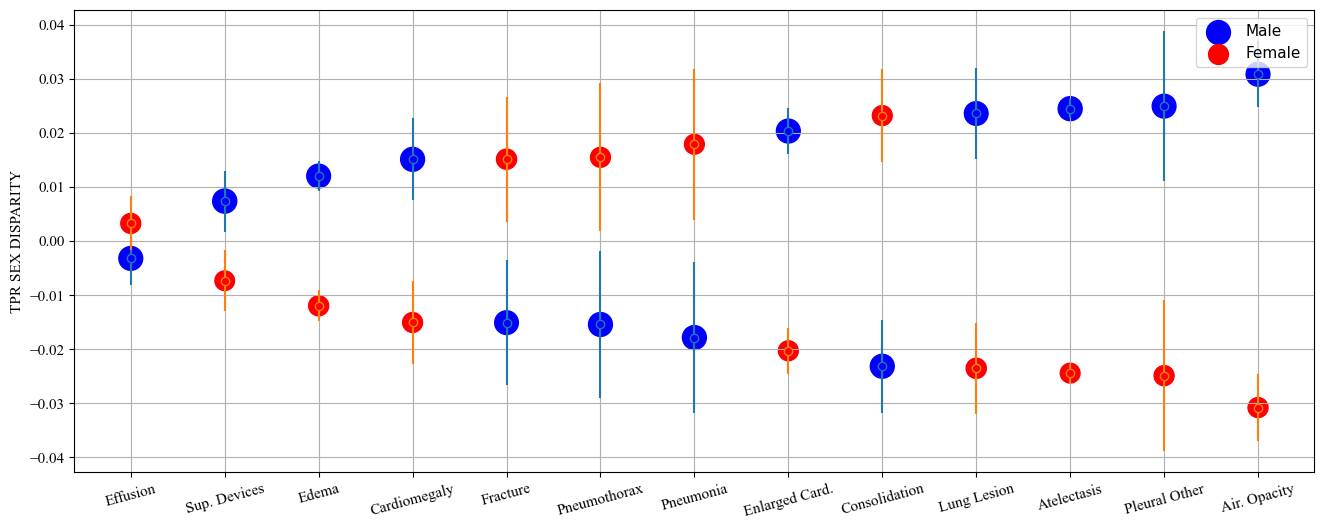

In [19]:

plt.rcParams.update({'font.size': font_size})

plt.figure(figsize=(16,height))
plt.scatter(sex_tpr_disp_df['diseases_abbr'],sex_tpr_disp_df['Gap_M_mean'],
            s= np.multiply(sex_tpr_disp_df['%M'],500), marker='o',color='blue', label="Male")
plt.errorbar(sex_tpr_disp_df['diseases_abbr'],sex_tpr_disp_df['Gap_M_mean'],
             yerr = sex_tpr_disp_df['CI_M'],fmt='o',mfc='blue')
plt.scatter(sex_tpr_disp_df['diseases_abbr'],sex_tpr_disp_df['Gap_F_mean'],
            s= np.multiply(sex_tpr_disp_df['%F'],500), marker='o',color='red', label="Female")
plt.errorbar(sex_tpr_disp_df['diseases_abbr'],sex_tpr_disp_df['Gap_F_mean'],
             yerr = sex_tpr_disp_df['CI_F'],fmt='o',mfc='red')

plt.xticks(rotation=rotation_degree,fontsize=font_size,fontname='Times New Roman')
plt.yticks(fontsize=font_size,fontname='Times New Roman')
plt.ylabel("TPR SEX DISPARITY",fontsize=font_size,fontname='Times New Roman')
plt.legend()
plt.grid(True)
plt.savefig("./TPR_GAPS/TPR_Dis_SEX.pdf")


## 2. Age

In [20]:
age_dataframes = [seed_19_age, seed_31_age, seed_38_age, seed_47_age, seed_77_age]
result_age_df= pd.concat(age_dataframes)

result_age_grouped =result_age_df.groupby("diseases")
result_age_grouped_stat = result_age_grouped.describe()


In [21]:
age_df_40_mean = result_age_grouped_stat['%40-60']['mean']
age_df_40_gap = result_age_grouped_stat['Gap_40-60']["mean"]
age_df_40_ci = significance_level*result_age_grouped_stat['Gap_40-60']["std"]/np.sqrt(number_of_runs)

In [22]:
age_df_60_mean = result_age_grouped_stat['%60-80']['mean']
age_df_60_gap = result_age_grouped_stat['Gap_60-80']["mean"]
age_df_60_ci = significance_level*result_age_grouped_stat['Gap_60-80']["std"]/np.sqrt(number_of_runs)

In [23]:
age_df_20_mean = result_age_grouped_stat['%20-40']['mean']
age_df_20_gap = result_age_grouped_stat['Gap_20-40']["mean"]
age_df_20_ci = significance_level*result_age_grouped_stat['Gap_20-40']["std"]/np.sqrt(number_of_runs)

In [24]:
age_df_80_mean = result_age_grouped_stat['%80+']['mean']
age_df_80_gap = result_age_grouped_stat['Gap_80+']["mean"]
age_df_80_ci = significance_level*result_age_grouped_stat['Gap_80+']["std"]/np.sqrt(number_of_runs)

In [25]:
age_df_0_mean = result_age_grouped_stat['%0-20']['mean']
age_df_0_gap = result_age_grouped_stat['Gap_0-20']["mean"]
age_df_0_ci = significance_level*result_age_grouped_stat['Gap_0-20']["std"]/np.sqrt(number_of_runs)

In [26]:
age_tpr_disp=pd.DataFrame(pd.DataFrame(diseases, columns=["diseases"]))

In [27]:
prcent_40_list = []
ci_40_list = []
gap_40_mean_list = []
diseases_abbr_list = []
distance_list = []

prcent_60_list = []
ci_60_list = []
prcent_60_list = []
gap_60_mean_list = []

prcent_20_list = []
ci_20_list = []
prcent_20_list = []
gap_20_mean_list = []

prcent_80_list = []
ci_80_list = []
prcent_80_list = []
gap_80_mean_list = []

prcent_0_list = []
ci_0_list = []
prcent_0_list = []
gap_0_mean_list = []
mean_list = []


In [28]:
for disease in diseases:
    mean_list = []
    cleaned_mean_gap_list = []
    prcent_40_list.append(age_df_40_mean[disease])
    gap_40_mean_list.append(age_df_40_gap[disease])
    ci_40_list.append(age_df_40_ci[disease])
    mean_list.append(age_df_40_gap[disease])

    prcent_60_list.append(age_df_60_mean[disease])
    gap_60_mean_list.append(age_df_60_gap[disease])
    ci_60_list.append(age_df_60_ci[disease])
    mean_list.append(age_df_60_gap[disease])

    prcent_20_list.append(age_df_20_mean[disease])
    gap_20_mean_list.append(age_df_20_gap[disease])
    ci_20_list.append(age_df_20_ci[disease])
    mean_list.append(age_df_20_gap[disease])

    prcent_80_list.append(age_df_80_mean[disease])
    gap_80_mean_list.append(age_df_80_gap[disease])
    ci_80_list.append(age_df_80_ci[disease])
    mean_list.append(age_df_80_gap[disease])

    prcent_0_list.append(age_df_0_mean[disease])
    gap_0_mean_list.append(age_df_0_gap[disease])
    ci_0_list.append(age_df_0_ci[disease])
    mean_list.append(age_df_0_gap[disease])


    cleaned_mean_gap_list = [x for x in mean_list if str(x) != 'nan']
    distance_list.append(np.max(cleaned_mean_gap_list) - np.min(cleaned_mean_gap_list))
    diseases_abbr_list.append(diseases_abbr[disease])

In [29]:
d = {'diseases': diseases, 'diseases_abbr': diseases_abbr_list, 'Distance': distance_list,
     "%40-60": prcent_40_list, 'Gap_40-60_mean': gap_40_mean_list, 'CI_40-60': ci_40_list,
     "%60-80": prcent_60_list, 'Gap_60-80_mean': gap_60_mean_list, 'CI_60-80': ci_60_list,
     "%20-40": prcent_20_list, 'Gap_20-40_mean': gap_20_mean_list, 'CI_20-40': ci_20_list,
     "%80-": prcent_80_list, 'Gap_80-_mean': gap_80_mean_list, 'CI_80-': ci_80_list,
     "%0-20": prcent_0_list, 'Gap_0-20_mean': gap_0_mean_list, 'CI_0-20': ci_0_list
     }
age_tpr_disp_df = pd.DataFrame(d)

In [30]:
age_tpr_disp_df = age_tpr_disp_df.sort_values(by ='Distance' )
age_tpr_disp_df.to_csv("./TPR_GAPS/age_tpr_disp.csv")

In [31]:
age_tpr_disp_df

,diseases,diseases_abbr,Distance,%40-60,Gap_40-60_mean,CI_40-60,%60-80,Gap_60-80_mean,CI_60-80,%20-40,Gap_20-40_mean,CI_20-40,%80-,Gap_80-_mean,CI_80-,%0-20,Gap_0-20_mean,CI_0-20
9,Pleural Effusion,Effusion,0.035544,0.173672,0.001417,0.001181,0.264187,0.008098,0.002690,0.055556,-0.020427,0.006351,0.124002,0.004418,0.007171,0.004133,-0.027446,0.010993
2,Lung Opacity,Air. Opacity,0.040520,0.205451,-0.003062,0.006002,0.300723,0.019447,0.008072,0.075250,-0.021074,0.010189,0.140990,0.017993,0.010039,0.004839,-0.016073,0.015462
1,Cardiomegaly,Cardiomegaly,0.048173,0.191014,-0.008333,0.009361,0.291435,0.015188,0.009538,0.062713,-0.024802,0.010061,0.153373,0.023371,0.010179,0.004546,-0.001435,0.005547
4,Edema,Edema,0.062630,0.198770,-0.007115,0.011471,0.309994,0.021628,0.004842,0.071212,-0.024748,0.011603,0.159677,0.036906,0.005431,0.004680,-0.025724,0.028005
0,Enlarged Cardiomediastinum,Enlarged Card.,0.063017,0.260563,0.000000,0.000000,0.388536,0.024920,0.001539,0.090413,-0.016074,0.006585,0.196880,0.035694,0.003055,0.005982,-0.027322,0.023617
5,Consolidation,Consolidation,0.068887,0.249975,0.003254,0.006352,0.379935,0.014388,0.003964,0.092449,-0.009423,0.012032,0.172787,0.000025,0.004114,0.005415,-0.054500,0.043498
12,Support Devices,Sup. Devices,0.088424,0.200121,0.000899,0.001081,0.254314,0.004196,0.005271,0.078725,-0.006854,0.004964,0.096312,-0.036142,0.015406,0.005899,0.052282,0.013550
7,Atelectasis,Atelectasis,0.088527,0.197654,0.000000,0.000000,0.295261,0.019610,0.004880,0.067291,-0.025288,0.005718,0.136822,0.012209,0.008888,0.004613,-0.068917,0.012086
10,Pleural Other,Pleural Other,0.136085,0.273323,0.052587,0.006744,0.364302,0.067130,0.015330,0.099075,-0.010641,0.020857,0.177332,-0.029535,0.031483,0.005783,-0.068955,0.012162
11,Fracture,Fracture,0.150757,0.251621,0.006387,0.007874,0.373763,0.021894,0.013031,0.104401,-0.012171,0.030476,0.192085,-0.016675,0.029704,0.006653,-0.128862,0.093178


In [32]:

# Extract just the Gap columns in the right order
gap_cols = [
    'Gap_0-20_mean', 'Gap_20-40_mean', 'Gap_40-60_mean',
    'Gap_60-80_mean'
]

ci_cols = [
    'CI_0-20', 'CI_20-40', 'CI_40-60',
    'CI_60-80'
]

gap_df = age_tpr_disp_df[gap_cols]


# Store results
pairs = list(combinations(gap_cols, 2))
pvals = []
tstats = []

for a, b in pairs:
    t_stat, p_val = ttest_rel(gap_df[a], gap_df[b], nan_policy='omit')
    tstats.append(t_stat)
    pvals.append(p_val)

# Multiple comparisons correction (e.g., Bonferroni or FDR)
reject, pvals_corrected, _, _ = smm.multipletests(pvals, method='bonferroni')

# Report
for i, (a, b) in enumerate(pairs):
    print(f"{a} vs {b}: t={tstats[i]:.4f}, p={pvals[i]:.4f}, corrected_p={pvals_corrected[i]:.4f}, significant={reject[i]}")
    

Gap_0-20_mean vs Gap_20-40_mean: t=-1.3459, p=0.2032, corrected_p=1.0000, significant=False
Gap_0-20_mean vs Gap_40-60_mean: t=-2.0025, p=0.0684, corrected_p=0.4101, significant=False
Gap_0-20_mean vs Gap_60-80_mean: t=-2.3570, p=0.0362, corrected_p=0.2175, significant=False
Gap_20-40_mean vs Gap_40-60_mean: t=-1.3740, p=0.1946, corrected_p=1.0000, significant=False
Gap_20-40_mean vs Gap_60-80_mean: t=-1.9279, p=0.0779, corrected_p=0.4672, significant=False
Gap_40-60_mean vs Gap_60-80_mean: t=-2.1128, p=0.0562, corrected_p=0.3375, significant=False


In [33]:

df = age_tpr_disp_df

# Define the columns to use
gap_cols = [
    'Gap_0-20_mean',
    'Gap_20-40_mean',
    'Gap_40-60_mean',
    'Gap_60-80_mean',
    'Gap_80-_mean'
]

# Drop rows with missing values in those columns
gap_df = df[gap_cols].dropna()

# Extract values into 4 separate lists (one per group)
group_0_20 = gap_df['Gap_0-20_mean'].tolist()
group_20_40 = gap_df['Gap_20-40_mean'].tolist()
group_40_60 = gap_df['Gap_40-60_mean'].tolist()
group_60_80 = gap_df['Gap_60-80_mean'].tolist()
group_80 = gap_df['Gap_80-_mean'].tolist()

# Perform one-way ANOVA across the groups
f_stat, p_val = f_oneway(group_0_20, group_20_40, group_40_60, group_60_80,group_80)

# Show results

print(f"ANOVA result: F-statistic = {f_stat:.3f}, p-value = {p_val:.3f} significant={p_val < 0.05}")


ANOVA result: F-statistic = 3.198, p-value = 0.019 significant=True


In [34]:
plt.rcParams.update({'font.size': font_size})

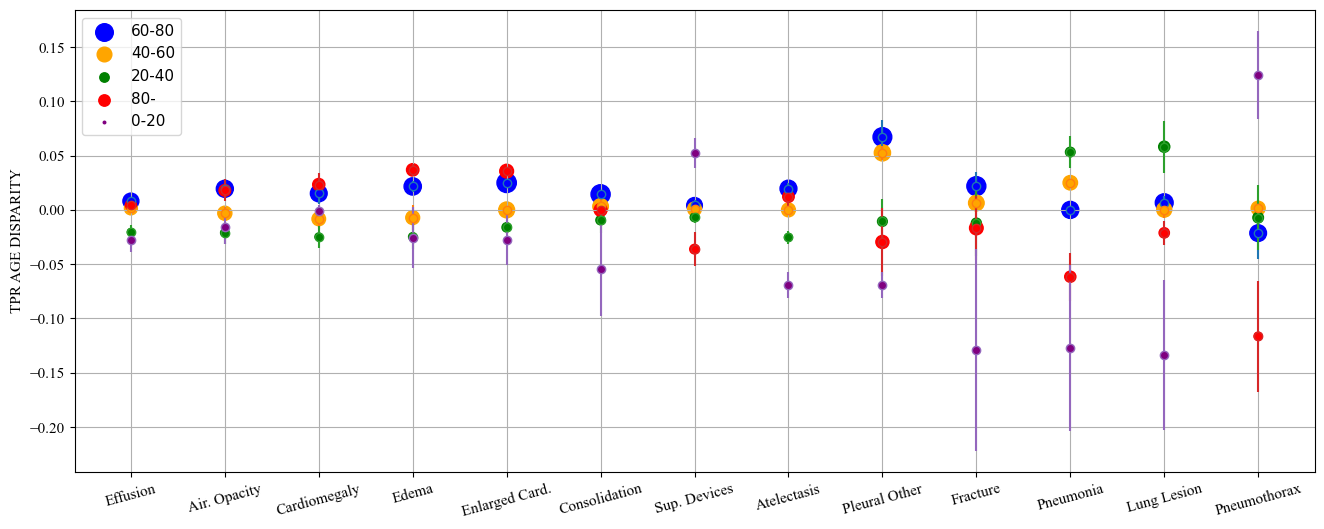

In [35]:
plt.figure(figsize=(16,height))
plt.scatter(age_tpr_disp_df['diseases_abbr'],age_tpr_disp_df['Gap_60-80_mean'],
            s= np.multiply(age_tpr_disp_df['%60-80'],500), marker='o',color='blue', label="60-80")
plt.errorbar(age_tpr_disp_df['diseases_abbr'],age_tpr_disp_df['Gap_60-80_mean'],
             yerr = age_tpr_disp_df['CI_60-80'],fmt='o',mfc='blue')
plt.scatter(age_tpr_disp_df['diseases_abbr'],age_tpr_disp_df['Gap_40-60_mean'],
            s= np.multiply(age_tpr_disp_df['%40-60'],500), marker='o',color='orange', label="40-60")
plt.errorbar(age_tpr_disp_df['diseases_abbr'],age_tpr_disp_df['Gap_40-60_mean'],
             yerr = age_tpr_disp_df['CI_40-60'],fmt='o',mfc='orange')
plt.scatter(age_tpr_disp_df['diseases_abbr'],age_tpr_disp_df['Gap_20-40_mean'],
            s= np.multiply(age_tpr_disp_df['%20-40'],500), marker='o',color='green', label="20-40")
plt.errorbar(age_tpr_disp_df['diseases_abbr'],age_tpr_disp_df['Gap_20-40_mean'],
             yerr = age_tpr_disp_df['CI_20-40'],fmt='o',mfc='green')
plt.scatter(age_tpr_disp_df['diseases_abbr'],age_tpr_disp_df['Gap_80-_mean'],
            s= np.multiply(age_tpr_disp_df['%80-'],500), marker='o',color='red', label="80-")
plt.errorbar(age_tpr_disp_df['diseases_abbr'],age_tpr_disp_df['Gap_80-_mean'],
             yerr = age_tpr_disp_df['CI_80-'],fmt='o',mfc='red')
plt.scatter(age_tpr_disp_df['diseases_abbr'],age_tpr_disp_df['Gap_0-20_mean'],
            s= np.multiply(age_tpr_disp_df['%0-20'],500), marker='o',color='purple', label="0-20")
plt.errorbar(age_tpr_disp_df['diseases_abbr'],age_tpr_disp_df['Gap_0-20_mean'],
             yerr = age_tpr_disp_df['CI_0-20'],fmt='o',mfc='purple')


plt.xticks(rotation = rotation_degree,fontsize=font_size,fontname='Times New Roman')
plt.ylabel("TPR AGE DISPARITY",fontsize=font_size,fontname='Times New Roman')
plt.yticks(fontsize=font_size,fontname='Times New Roman')
plt.legend()
plt.grid(True)
plt.savefig("./TPR_GAPS/TPR_Dis_AGE.pdf")

## 3. Race

In [36]:
race_dataframes = [seed_19_race, seed_31_race, seed_38_race, seed_47_race, seed_77_race]
result_race_df= pd.concat(race_dataframes)

result_race_grouped =result_race_df.groupby("diseases")
result_race_grouped_stat = result_race_grouped.describe()

In [37]:
result_race_grouped_stat

%White                                     \
                            count      mean  std       min       25%   
diseases                                                               
Atelectasis                   5.0  0.677256  0.0  0.677256  0.677256   
Cardiomegaly                  5.0  0.653340  0.0  0.653340  0.653340   
Consolidation                 5.0  0.666732  0.0  0.666732  0.666732   
Edema                         5.0  0.662935  0.0  0.662935  0.662935   
Enlarged Cardiomediastinum    5.0  0.652582  0.0  0.652582  0.652582   
Fracture                      5.0  0.660525  0.0  0.660525  0.660525   
Lung Lesion                   5.0  0.656690  0.0  0.656690  0.656690   
Lung Opacity                  5.0  0.665128  0.0  0.665128  0.665128   
No Finding                    5.0  0.609506  0.0  0.609506  0.609506   
Pleural Effusion              5.0  0.688384  0.0  0.688384  0.688384   
Pleural Other                 5.0  0.619892  0.0  0.619892  0.619892   
Pneumonia                     5.0  0.658039  0.0  0.658039  0.658039   
Pneumothorax                  5.0  0.728803  0.0  0.728803  0.728803   
Support Devices               5.0  0.679420  0.0  0.679420  0.679420   

                                                         Gap_White            \
                                 50%       75%       max     count      mean   
diseases                                                                       
Atelectasis                 0.677256  0.677256  0.677256       5.0  0.021083   
Cardiomegaly                0.653340  0.653340  0.653340       5.0 -0.004444   
Consolidation               0.666732  0.666732  0.666732       5.0  0.022798   
Edema                       0.662935  0.662935  0.662935       5.0  0.006338   
Enlarged Cardiomediastinum  0.652582  0.652582  0.652582       5.0  0.014706   
Fracture                    0.660525  0.660525  0.660525       5.0  0.027014   
Lung Lesion                 0.656690  0.656690  0.656690       5.0 -0.029712   
Lung Opacity                0.665128  0.665128  0.665128       5.0  0.004157   
No Finding                  0.609506  0.609506  0.609506       5.0 -0.054647   
Pleural Effusion            0.688384  0.688384  0.688384       5.0  0.019218   
Pleural Other               0.619892  0.619892  0.619892       5.0  0.004562   
Pneumonia                   0.658039  0.658039  0.658039       5.0 -0.011489   
Pneumothorax                0.728803  0.728803  0.728803       5.0  0.017675   
Support Devices             0.679420  0.679420  0.679420       5.0 -0.012115   

                            ... %American           Gap_American            \
                            ...       75%       max        count      mean   
diseases                    ...                                              
Atelectasis                 ...  0.010677  0.010677          5.0 -0.021083   
Cardiomegaly                ...  0.011700  0.011700          5.0  0.004444   
Consolidation               ...  0.010338  0.010338          5.0 -0.022798   
Edema                       ...  0.011930  0.011930          5.0 -0.024299   
Enlarged Cardiomediastinum  ...  0.014236  0.014236          5.0 -0.017874   
Fracture                    ...  0.012965  0.012965          5.0 -0.025006   
Lung Lesion                 ...  0.012272  0.012272          5.0  0.076854   
Lung Opacity                ...  0.011012  0.011012          5.0 -0.004157   
No Finding                  ...  0.013053  0.013053          5.0 -0.116063   
Pleural Effusion            ...  0.010649  0.010649          5.0 -0.049853   
Pleural Other               ...  0.015806  0.015806          5.0  0.004911   
Pneumonia                   ...  0.011808  0.011808          5.0  0.011489   
Pneumothorax                ...  0.005502  0.005502          5.0 -0.008812   
Support Devices             ...  0.012570  0.012570          5.0  0.044496   

                                                                              \
                                 s

In [38]:
race_tpr_disp=pd.DataFrame(pd.DataFrame(diseases, columns=["diseases"]))

In [39]:
race_df_white_mean = result_race_grouped_stat['%White']['mean']
race_df_white_gap = result_race_grouped_stat['Gap_White']["mean"]
race_df_white_ci= significance_level * result_race_grouped_stat['Gap_White']["std"] / np.sqrt(number_of_runs)

In [40]:
race_df_black_mean = result_race_grouped_stat['%Black']['mean']
race_df_black_gap = result_race_grouped_stat['Gap_Black']["mean"]
race_df_black_ci= significance_level * result_race_grouped_stat['Gap_Black']["std"] / np.sqrt(number_of_runs)

In [41]:
race_df_hisp_mean = result_race_grouped_stat['%Hisp']['mean']
race_df_hisp_gap = result_race_grouped_stat['Gap_Hisp']["mean"]
race_df_hisp_ci= significance_level * result_race_grouped_stat['Gap_Hisp']["std"] / np.sqrt(number_of_runs)


In [42]:
race_df_other_mean = result_race_grouped_stat['%Other']['mean']
race_df_other_gap = result_race_grouped_stat['Gap_Other']["mean"]
race_df_other_ci= significance_level * result_race_grouped_stat['Gap_Other']["std"] / np.sqrt(number_of_runs)


In [43]:
race_df_asian_mean = result_race_grouped_stat['%Asian']['mean']
race_df_asian_gap = result_race_grouped_stat['Gap_Asian']["mean"]
race_df_asian_ci= significance_level * result_race_grouped_stat['Gap_Asian']["std"] / np.sqrt(number_of_runs)

In [44]:
race_df_american_mean = result_race_grouped_stat['%American']['mean']
race_df_american_gap = result_race_grouped_stat['Gap_American']["mean"]
race_df_american_ci= significance_level * result_race_grouped_stat['Gap_American']["std"] / np.sqrt(number_of_runs)


In [45]:
percent_asian_list = []
ci_asian_list = []
gap_asian_mean_list = []


ci_american_list = []
percent_american_list = []
gap_american_mean_list = []

percent_white_list = []
ci_white_list = []
gap_white_mean_list = []

percent_black_list = []
ci_black_list = []
gap_black_mean_list = []

percent_hisp_list = []
ci_hisp_list = []
gap_hisp_mean_list = []

percent_other_list = []
ci_other_list = []
gap_other_mean_list = []

diseases_abbr_list = []
distance_list = []


In [46]:
for disease in diseases:
    mean_list = []
    percent_black_list.append(race_df_black_mean[disease])
    gap_black_mean_list.append(race_df_black_gap[disease])
    ci_black_list.append(race_df_black_ci[disease])
    mean_list.append(race_df_black_gap[disease])

    percent_hisp_list.append(race_df_hisp_mean[disease])
    gap_hisp_mean_list.append(race_df_hisp_gap[disease])
    ci_hisp_list.append(race_df_hisp_ci[disease])
    mean_list.append(race_df_hisp_gap[disease])

    percent_other_list.append(race_df_other_mean[disease])
    gap_other_mean_list.append(race_df_other_gap[disease])
    ci_other_list.append(race_df_other_ci[disease])
    mean_list.append(race_df_other_gap[disease])

    percent_white_list.append(race_df_white_mean[disease])
    gap_white_mean_list.append(race_df_white_gap[disease])
    ci_white_list.append(race_df_white_ci[disease])
    mean_list.append(race_df_white_gap[disease])

    percent_asian_list.append(race_df_asian_mean[disease])
    gap_asian_mean_list.append(race_df_asian_gap[disease])
    ci_asian_list.append(race_df_asian_ci[disease])
    mean_list.append(race_df_asian_gap[disease])

    percent_american_list.append(race_df_american_mean[disease])
    gap_american_mean_list.append(race_df_american_gap[disease])
    ci_american_list.append(race_df_american_ci[disease])
    mean_list.append(race_df_american_gap[disease])

    cleaned_mean_list= [x for x in mean_list if str(x) != 'nan']

    distance_list.append(np.max(cleaned_mean_list) - np.min(cleaned_mean_list))

    diseases_abbr_list.append(diseases_abbr[disease])

In [47]:
d = {'diseases': diseases, 'diseases_abbr': diseases_abbr_list, 'Distance': distance_list,
     "%White": percent_white_list, 'Gap_W_mean': gap_white_mean_list, 'CI_W': ci_white_list,
     "%Black": percent_white_list, 'Gap_B_mean': gap_black_mean_list, 'CI_B': ci_black_list,
     "%Hisp": percent_hisp_list, 'Gap_H_mean': gap_hisp_mean_list, 'CI_H': ci_hisp_list,
     "%Other": percent_other_list, 'Gap_Ot_mean': gap_other_mean_list, 'CI_Ot': ci_other_list,
     "%Asian": percent_asian_list, 'Gap_As_mean': gap_asian_mean_list, 'CI_As': ci_asian_list,
     "%American": percent_american_list, 'Gap_Am_mean': gap_american_mean_list, 'CI_Am': ci_american_list
     }
race_tpr_disp_df = pd.DataFrame(d)
race_tpr_disp_df = race_tpr_disp_df.sort_values(by ='Distance')
race_tpr_disp_df.to_csv("./TPR_GAPS/race_tpr_disp.csv")

In [48]:
race_tpr_disp_df.columns

Index(['diseases', 'diseases_abbr', 'Distance', '%White', 'Gap_W_mean', 'CI_W',
       '%Black', 'Gap_B_mean', 'CI_B', '%Hisp', 'Gap_H_mean', 'CI_H', '%Other',
       'Gap_Ot_mean', 'CI_Ot', '%Asian', 'Gap_As_mean', 'CI_As', '%American',
       'Gap_Am_mean', 'CI_Am'],
      dtype='object')

In [49]:

# Extract just the Gap columns in the right order
gap_cols = [
    'Gap_W_mean', 'Gap_B_mean', 'Gap_H_mean',
    'Gap_Ot_mean', 'Gap_As_mean','Gap_Am_mean'
]

ci_cols = [
    'CI_0-20', 'CI_20-40', 'CI_40-60',
    'CI_60-80', 'CI_80-'
]

gap_df = race_tpr_disp_df[gap_cols]


# Store results
pairs = list(combinations(gap_cols, 2))
pvals = []
tstats = []

for a, b in pairs:
    t_stat, p_val = ttest_rel(gap_df[a], gap_df[b], nan_policy='omit')
    tstats.append(t_stat)
    pvals.append(p_val)

# Multiple comparisons correction (e.g., Bonferroni or FDR)
reject, pvals_corrected, _, _ = smm.multipletests(pvals, method='bonferroni')

# Report
for i, (a, b) in enumerate(pairs):
    print(f"{a} vs {b}: t={tstats[i]:.4f}, p={pvals[i]:.4f}, corrected_p={pvals_corrected[i]:.4f}, significant={reject[i]}")


Gap_W_mean vs Gap_B_mean: t=6.6859, p=0.0000, corrected_p=0.0003, significant=True
Gap_W_mean vs Gap_H_mean: t=6.0790, p=0.0001, corrected_p=0.0008, significant=True
Gap_W_mean vs Gap_Ot_mean: t=-4.7462, p=0.0005, corrected_p=0.0071, significant=True
Gap_W_mean vs Gap_As_mean: t=-5.5405, p=0.0001, corrected_p=0.0019, significant=True
Gap_W_mean vs Gap_Am_mean: t=0.6365, p=0.5364, corrected_p=1.0000, significant=False
Gap_B_mean vs Gap_H_mean: t=-1.7748, p=0.1013, corrected_p=1.0000, significant=False
Gap_B_mean vs Gap_Ot_mean: t=-7.3502, p=0.0000, corrected_p=0.0001, significant=True
Gap_B_mean vs Gap_As_mean: t=-7.2444, p=0.0000, corrected_p=0.0002, significant=True
Gap_B_mean vs Gap_Am_mean: t=-5.6317, p=0.0001, corrected_p=0.0017, significant=True
Gap_H_mean vs Gap_Ot_mean: t=-6.3431, p=0.0000, corrected_p=0.0006, significant=True
Gap_H_mean vs Gap_As_mean: t=-6.5427, p=0.0000, corrected_p=0.0004, significant=True
Gap_H_mean vs Gap_Am_mean: t=-3.4952, p=0.0044, corrected_p=0.0663, s

In [57]:

df = race_tpr_disp_df

# Define the columns to use
gap_cols = [
    'Gap_W_mean',
    'Gap_B_mean',
    'Gap_H_mean',
    'Gap_Ot_mean',
    'Gap_As_mean',
    'Gap_Am_mean'
]

# Drop rows with missing values in those columns
gap_df = df[gap_cols].dropna()

# Extract values into 4 separate lists (one per group)
group_W = gap_df['Gap_W_mean'].tolist()
group_B = gap_df['Gap_B_mean'].tolist()
group_H = gap_df['Gap_H_mean'].tolist()
group_O = gap_df['Gap_Ot_mean'].tolist()
group_A = gap_df['Gap_As_mean'].tolist()
group_Am = gap_df['Gap_Am_mean'].tolist()

# Perform one-way ANOVA across the groups
f_stat, p_val = f_oneway(group_W, group_B, group_H, group_O,group_A,group_Am)

print(f"ANOVA result: F-statistic = {f_stat:.3f}, p-value = {p_val:.3f} significant={p_val < 0.05}")


ANOVA result: F-statistic = 37.351, p-value = 0.000 significant=True


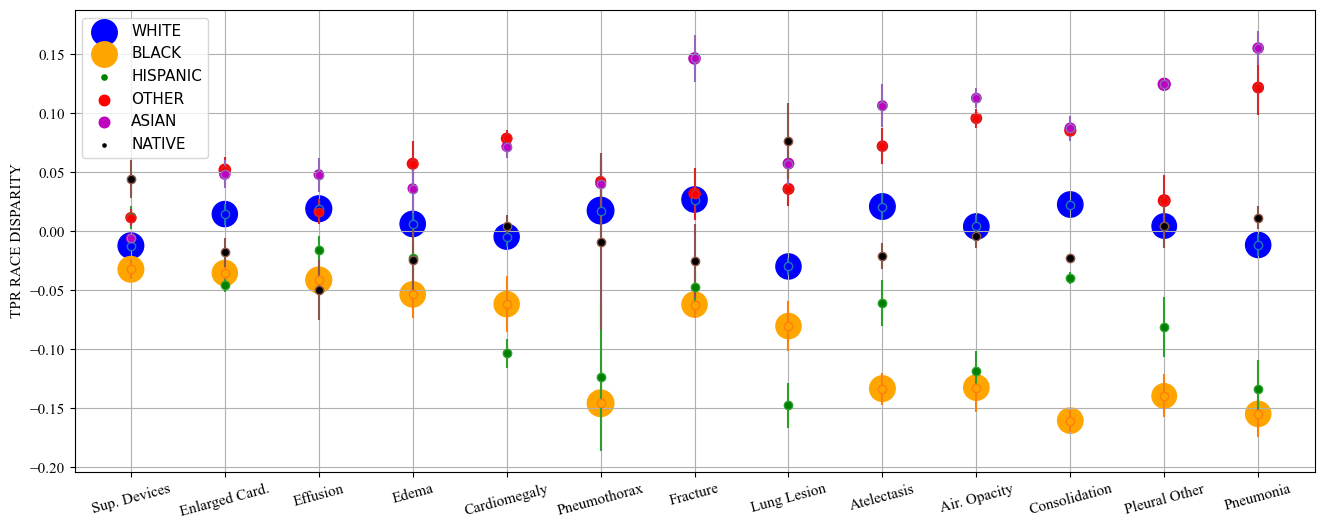

In [50]:
plt.rcParams.update({'font.size': font_size})
plt.figure(figsize=(16,height))

plt.scatter(race_tpr_disp_df['diseases_abbr'],race_tpr_disp_df['Gap_W_mean'],
            s= np.multiply(race_tpr_disp_df['%White'],500), marker='o',color='blue', label="WHITE")
plt.errorbar(race_tpr_disp_df['diseases_abbr'],race_tpr_disp_df['Gap_W_mean'],
             yerr = race_tpr_disp_df['CI_W'],fmt='o',mfc='blue')#ecolor='blue'

plt.scatter(race_tpr_disp_df['diseases_abbr'],race_tpr_disp_df['Gap_B_mean'],
            s= np.multiply(race_tpr_disp_df['%Black'],500), marker='o',color='orange', label="BLACK")
plt.errorbar(race_tpr_disp_df['diseases_abbr'],race_tpr_disp_df['Gap_B_mean'],
             yerr = race_tpr_disp_df['CI_B'],fmt='o',mfc='orange')

plt.scatter(race_tpr_disp_df['diseases_abbr'],race_tpr_disp_df['Gap_H_mean'],
            s= np.multiply(race_tpr_disp_df['%Hisp'],500), marker='o',color='green', label="HISPANIC")
plt.errorbar(race_tpr_disp_df['diseases_abbr'],race_tpr_disp_df['Gap_H_mean'],
             yerr = race_tpr_disp_df['CI_H'],fmt='o',mfc='green')

plt.scatter(race_tpr_disp_df['diseases_abbr'],race_tpr_disp_df['Gap_Ot_mean'],
            s= np.multiply(race_tpr_disp_df['%Other'],500), marker='o',color='r', label="OTHER")
plt.errorbar(race_tpr_disp_df['diseases_abbr'],race_tpr_disp_df['Gap_Ot_mean'],
             yerr = race_tpr_disp_df['CI_Ot'],fmt='o',mfc='r')

plt.scatter(race_tpr_disp_df['diseases_abbr'],race_tpr_disp_df['Gap_As_mean'],
            s= np.multiply(race_tpr_disp_df['%Asian'],500), marker='o',color='m', label="ASIAN")
plt.errorbar(race_tpr_disp_df['diseases_abbr'],race_tpr_disp_df['Gap_As_mean']
             ,yerr = race_tpr_disp_df['CI_As'],fmt='o',mfc='m')

plt.scatter(race_tpr_disp_df['diseases_abbr'],race_tpr_disp_df['Gap_Am_mean'],
            s= np.multiply(race_tpr_disp_df['%American'],500), marker='o',color='k', label="NATIVE")
plt.errorbar(race_tpr_disp_df['diseases_abbr'],race_tpr_disp_df['Gap_Am_mean'],
             yerr = race_tpr_disp_df['CI_Am'],fmt='o',mfc='k')

plt.xticks(rotation=rotation_degree,fontsize=font_size,fontname='Times New Roman')
plt.ylabel("TPR RACE DISPARITY",fontsize=font_size,fontname='Times New Roman')
plt.yticks(fontsize=font_size,fontname='Times New Roman')
plt.legend()
plt.grid(True)
plt.savefig("./TPR_GAPS/TPR_Dis_RACE.pdf")